In [3]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import math_optimization_library as optlib
import autograd.numpy as np
from matplotlib import gridspec
import math
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## Mathematical Optimization Series

# Part 1: Motivation and primitive methods

- In this post we motivate the study of **mathematical optimization**, and describe two naive methods of mathematical optimization - random evaluation and random search.

- Both approaches are extremely simple, but both have fundamental flaws!

- We discuss them primarily because they allow us to introduce a number of key concepts shared by almost all effective mathematical optimization tools divorced from the complications involved with more sophisticated algorithms.  

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.  

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# 1. Mathematical optimization and machine learning / deep learning

Every machine learning / deep learning learning problem has parameters that must be tuned properly to ensure optimal learning.

For example with simple linear regression (scalar input - scalar output) there are two: the slope and intercept of the linear model.  

These two parameters are tuned by forming what is called a *cost function* or *loss function*.

The proper tuning of linear regression parameters via the cost function corresponds geometrically to finding the values for the parameters that make the cost function as small as possible or, in other words, *minimize* it.

<img src="../../mlrefined_images/math_optimization_images/bigpicture_regression_optimization.png" width=500 height=250/>

This same idea holds true for regression with higher dimensional input, as well as classification.

<img src="../../mlrefined_images/math_optimization_images/bigpicture_classification_optimization.png" width=500 height=250/>

The tuning of these parameters require the *minimization of a cost function* can be formally written as

\begin{equation}
\underset{\mathbf{w}}{\mbox{minimize}}\,\,\,\,g\left(\mathbf{w}\right)
\end{equation}

One can use the first order optimality condition to find the minima.

These conditions however can very rarely be solved 'by hand': we must rely on algorithmic techniques to approximately find function minima. 

# 2.  Naive evaluation 

This is an idea that is so simple many might consider it trivial, but it is perhaps the first naive computational way one would try to uncover the global minima of an arbitrary function.

## 2.1  Uniform versus random evaluation

One can simply evaluate a function over a large number of its input points and taking the smallest result.  

There are, generally speaking, two ways of performing this evaluation - *uniformly* over an evenly spaced grid, or picking points at *random* in the input space.  

#### <span style="color:#a50e3e;">Example 1. </span> Evaluating a quadratic to determine its minimum

- Two quadratics: one in 2D (left panels), the other in 3D (right panels) both having a global minimum at zero

- uniform evaluation (top panels) vs. random evaluation (bottom panels)

<IPython.core.display.Javascript object>


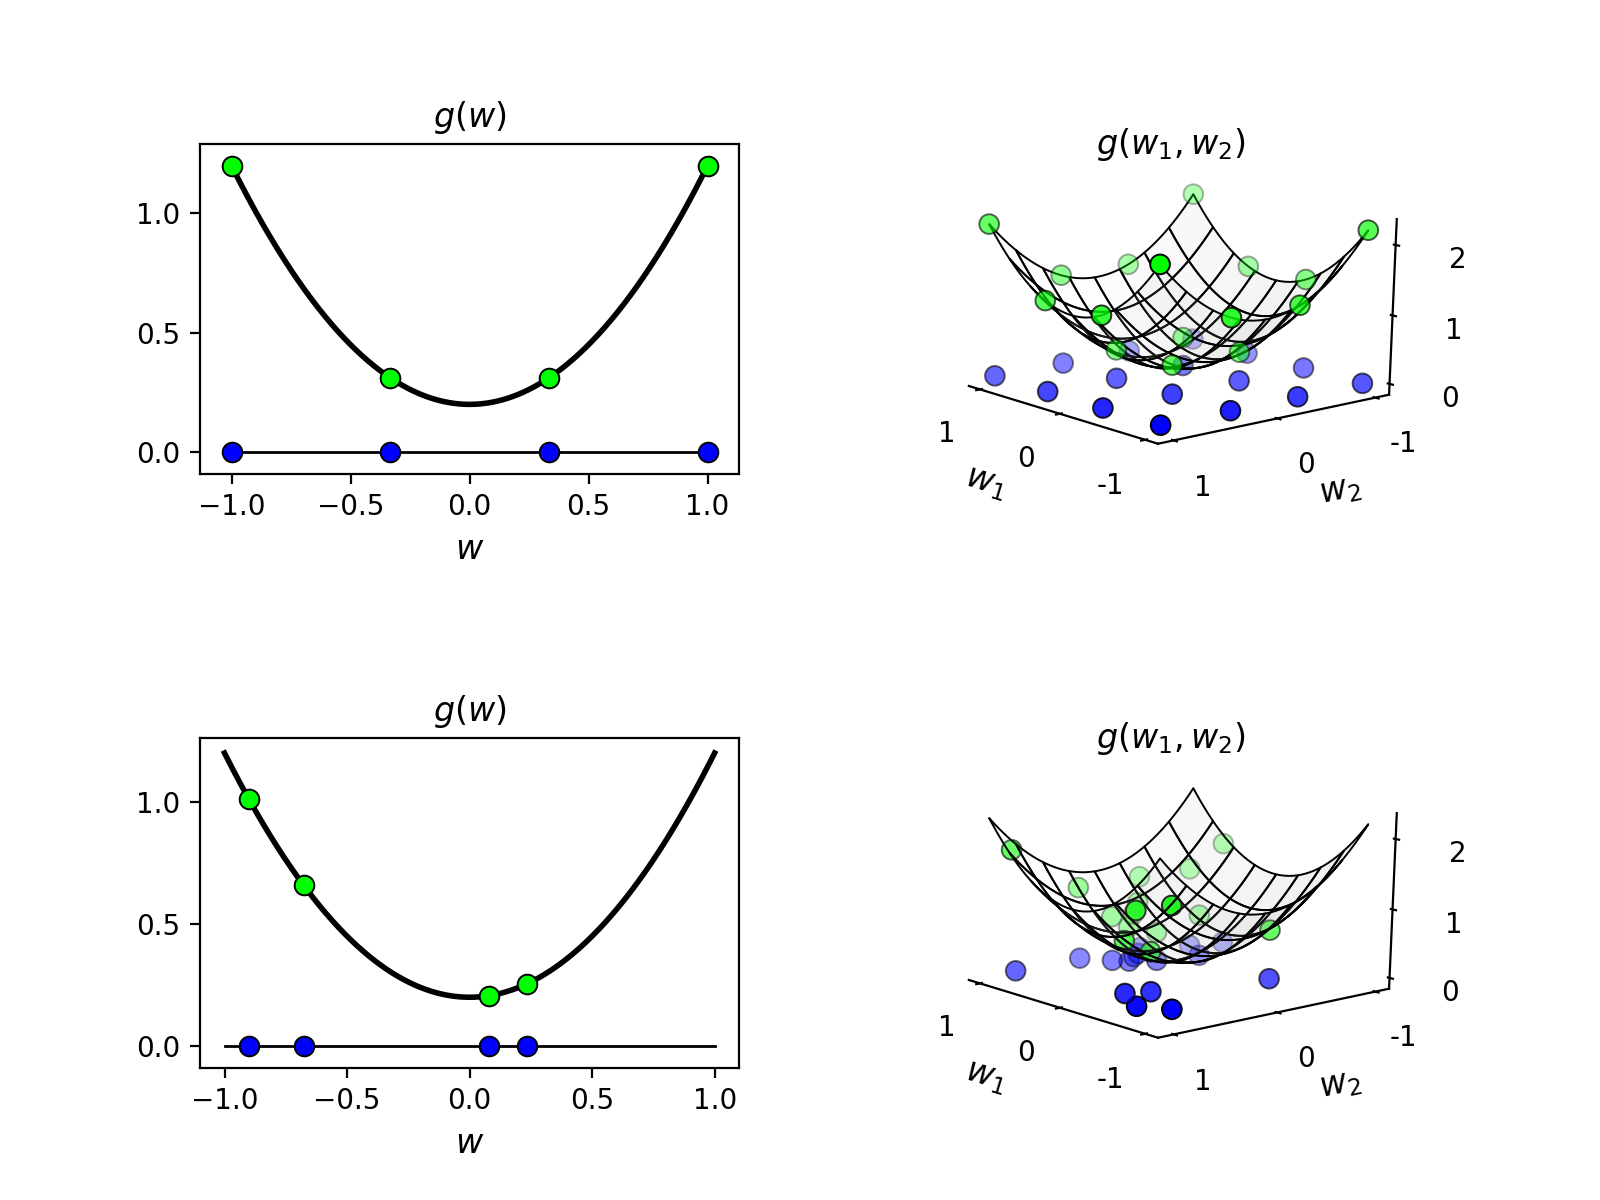

In [2]:
# define function
func = lambda w: np.dot((w-0).T,(w-0)) + 0.2
num_samples = 4
view = [20,140]

# plot 2d and 3d version, with even grid and randomly selected points
optlib.random_method_experiments.double_plot(func,num_samples,view = view)

By using enough samples - either in a even grid or randomly -  we could certainly find an input very close to the true global minimum.

<IPython.core.display.Javascript object>


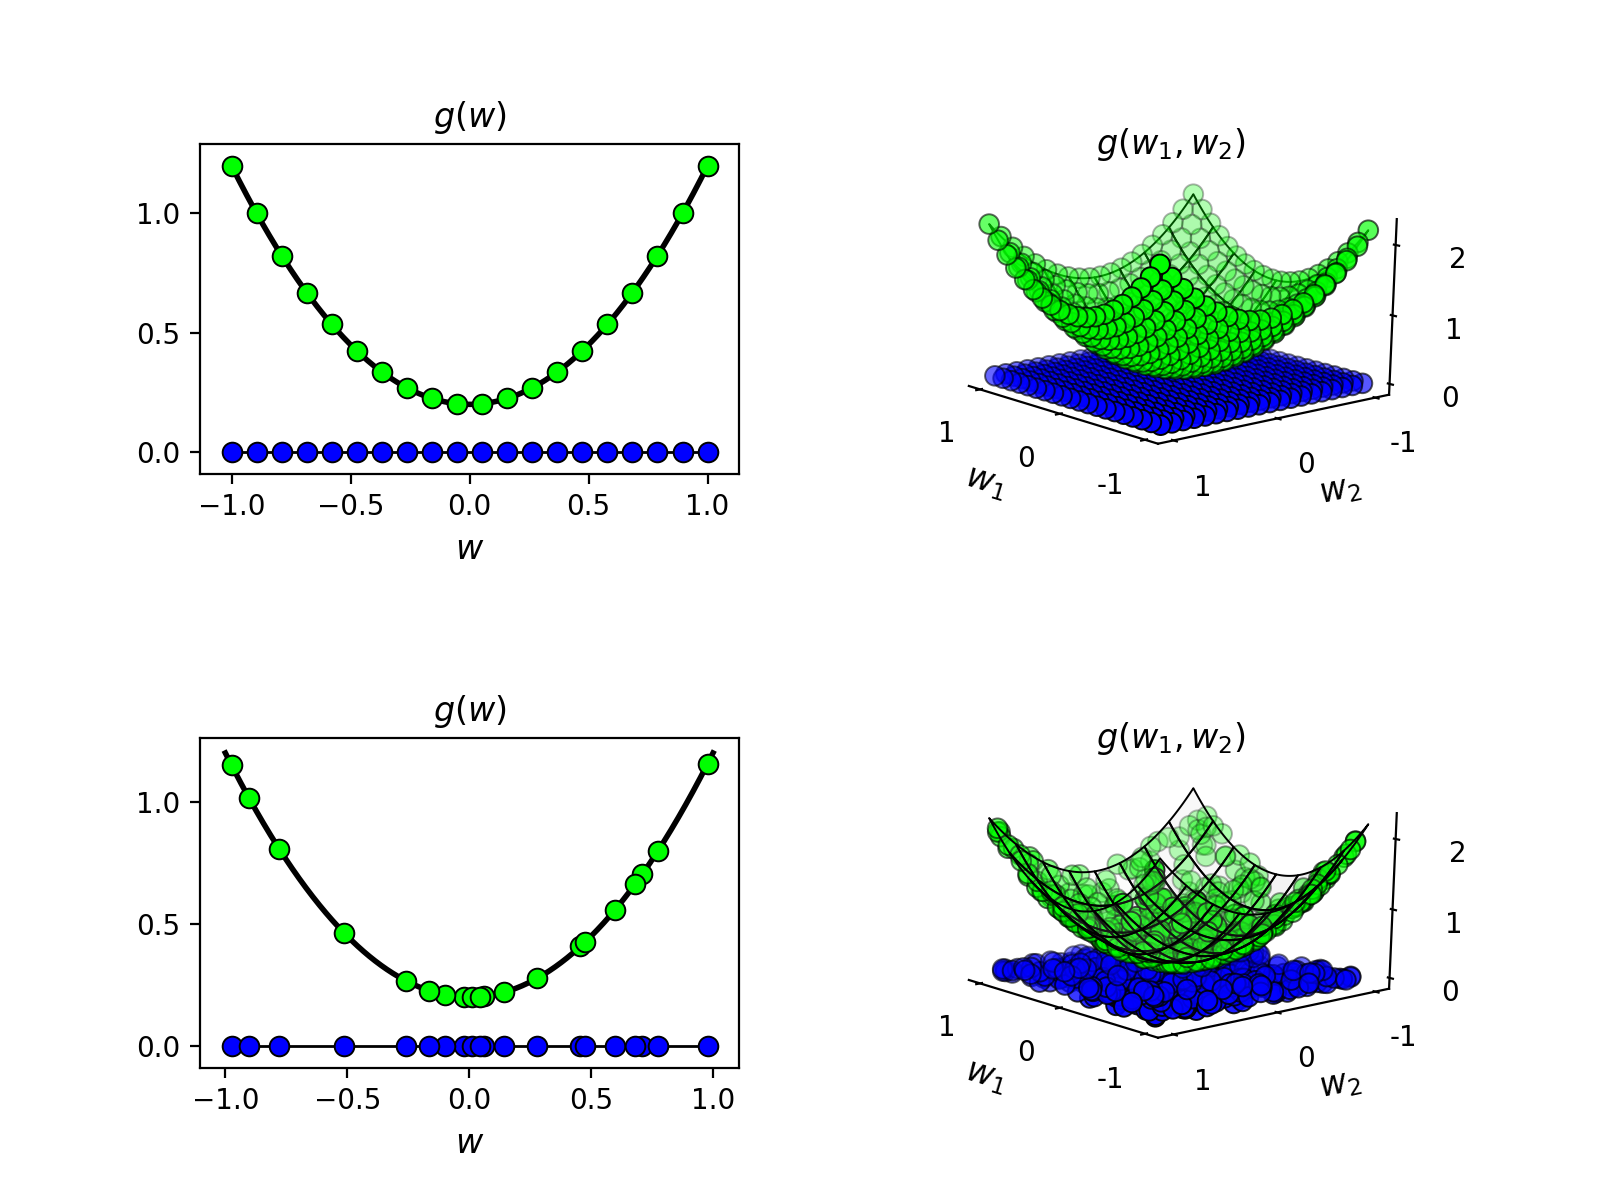

In [3]:
# define function
func = lambda w: np.dot(w.T,w) + 0.2
num_samples = 20
view = [20,140]

# plot 2d and 3d version, with even grid and randomly selected points
optlib.random_method_experiments.double_plot(func,num_samples,view = view)

## 2.2  The curse of dimensionality and the method of naive evaluation

We live in a world with three spatial dimensions, and as such we have evolved to have a good intuition/understanding of three-dimensional problems. 

Have you ever noticed that things get considerably easier when we go back to two dimensions, and extremely easier when we go all the way back to the one dimensional space - a simple line. This trend is not good news considering that in machine learning, we usually have to change course and study problems in dimensions much larger than three - sometimes in hundreds of millions or even billions.

The notion that analysis of problems in high dimensional spaces gets rapidly worse as we increase dimensionality is generally referred to as **the curse of dimensionality**, which has undesired consequences as we see now.   

### Naive evaluation with uniform samples

<img src="../../mlrefined_images/math_optimization_images/curse_1.png" width=600 height=250/>

The exponential growth in the number of samples/evaluations is hugely problematic when dealing with higher-dimensional spaces than $N=3$ dimensions: to maintain even this coarse sampling we would need $3^N$ samples in a general $N$ dimensional space.

### Naive evaluation with random samples

<img src="../../mlrefined_images/math_optimization_images/curse_2.png" width=600 height=250/>

As we increase the dimension of the input space the the average number of samples per unit hypercube drops exponentially, leaving many regions of the space without a single sample (or corresponding evaluation).

#### <span style="color:#a50e3e;">Example 2. </span> Evaluating a quadratic as its dimension increases

Consider the simple quadratic function $g(\mathbf{w}) = \mathbf{w}^T\mathbf{w}$ whose minimum is always zero regardless of the input dimension $N$.

In this experiment we create a range of these quadratics for input dimension $N=1$ to $N = 100$.

We sample the input space of each quadratic $10,000$ times randomly and uniformly on the hypercube $[-1,1]\times [-1,1] \times \cdots \times [-1,1]$ (this hypercube has $N$ sides).

The printout below shows the *minimum* value attained for each dimensional quadratic after $100$, $1,000$, and $10,000$ samples.

<IPython.core.display.Javascript object>


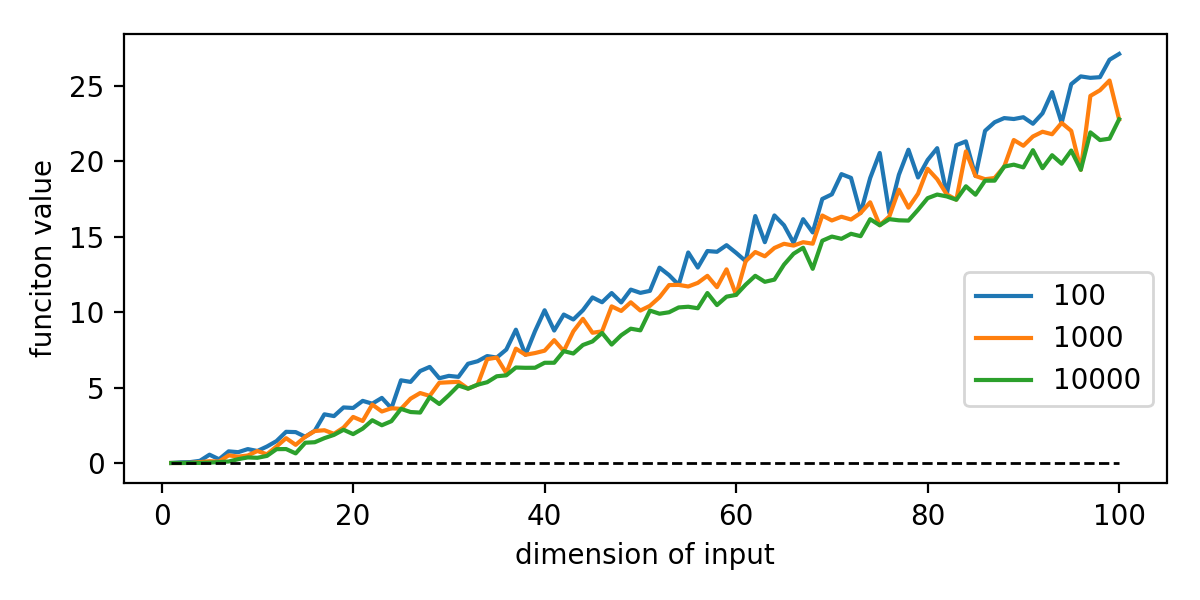

In [4]:
# run experiment for global random evaluation
optlib.random_method_experiments.random_eval_experiment()

The minimum value attained even after $10,000$ random samples increases substantially as the dimension of the quadratic increases - all due to the curse of dimensionality.

## 2.3 Conclusions

Finding a global minimum of a function by naive evaluation - while fine for one or two dimensions - quickly becomes infeasible as the input dimension increases, rendering it unusable for most modern applications - especially machine learning / deep learning -  where functions can have input dimension ranging from the hundreds to the hundreds of millions.

# 3.  Random local search

In this Section we describe our first mathematical optimization algorithms - *random local search*.

As opposed to an approach like naive evaluation where each function evaluation is performed independently of all others, with random local search each evaluation builds on the work of its predecessors to find lower and lower portions of a function.

While random local search is also crippled by the curse of dimensionality, there is a great amount to be learned by understanding its basic workings.

## 3.1  Local search methods: the big picture

A generic local search scheme for minimizing a general function $g$ work as follows:

1) Start at some *initial point* $\mathbf{w}^{0}$.

2) Take iterative steps in the input space denoted by $\mathbf{w}^{1},\,\mathbf{w}^{2},\,\ldots$, with corresponding sequence of evaluations $g(\mathbf{w}^{0}),\, g(\mathbf{w}^{1}),\, g(\mathbf{w}^{2}),...$.  Steps are taken in such a way so the sequence of evaluations is (in general) decreasing.

3) Repeat step 2) until the sequence of evaluations converges, or a maximum total number of iterations has been reached.


<p>
<img src= '../../mlrefined_images/math_optimization_images/Fig_2_6.png' width="75%" height="100%"/>
</p>

The array of algorithms designed under this general set of principles is extremely broad, with random local search comprising perhaps the most simple example.

## 3.2  Random local search

1)  We initialize at a random point $\mathbf{w}^0$, where we have a corresponding evaluation $g(\mathbf{w}^0)$. 


2)  At the $k^{th}$ step in the process we begin at a point $\mathbf{w}^k$ and look around locally at $P$ random candidate points a unit length away from $\mathbf{w}^k$ in the input space.  Each candidate is constructed by choosing a random unit direction $\mathbf{d}$ from $\mathbf{w}^k$, forming the new candidate point as $\mathbf{w}_{\text{candidate}} = \mathbf{w}^k - \mathbf{d}$.  We then evaluate all $P$ candidate points through our function $g$, denoting by $\mathbf{w}^{k+1}$ the point giving the lowest evaluation. 


3)  If $g(\mathbf{w}^{k+1}) < g(\mathbf{w}^k)$, then we move to $\mathbf{w}^{k+1}$ and begin step 2) again letting $k+1 \longleftarrow k$.  Otherwise we stop the procedure.

Once complete the local search algorithm produces a sequence of points


\begin{array}
\
\mathbf{w}^0 \\
\mathbf{w}^1 = \mathbf{w}^0 - \mathbf{d}^0  \\
\mathbf{w}^2 = \mathbf{w}^1 - \mathbf{d}^1  \\
\mathbf{w}^3 = \mathbf{w}^2 - \mathbf{d}^2  \\
\vdots \\
\mathbf{w}^K = \mathbf{w}^{K-1} - \mathbf{d}^{K-1}
\end{array}

where $\mathbf{d}^{k-1}$ is the direction traveled at the $k^{th}$ step of the process, and $g(\mathbf{w}^0) > g(\mathbf{w}^1) > g(\mathbf{w}^2) > \cdots > g(\mathbf{w}^{K}) $.

This idea illustrated figuratively in the picture below, where at each step only one of the three candidates produces a descent direction - drawn as a yellow arrow - while the other two are ascent directions drawn in blue.

<p>
<img src= '../../mlrefined_images/math_optimization_images/local.png' width="75%" height="75%"/>
</p>

As with the naive evaluation method instead of choosing directions at random we could choose them uniformly here.  However for a similar as with discussed previously with the naive evaluation method, being by choosing random directions we have a higher chance of stumbling on a descent direction by chance using fewer samples, we stick with choosing directions randomly here.

This process is described in a formal algorithm box below.

### Random local search

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; **Input:** initial point $\mathbf{w}^0$, maximum number of steps $K$, number of random samples per step $P$ <br>


<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,k = 1...K$<br>


<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $p=1...P$ <br>



<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>compute</code> random direction $\mathbf{d}^p$, form candidate point $\mathbf{w}^{k-1} + \mathbf{d}^p$ <br>



<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>set</code> $s = \underset{p=1...P}{\text{argmin}}\,\,g\left(\mathbf{w}^{k-1} + \mathbf{d}^p\right)$, and $\mathbf{d}^{k} = \mathbf{d}^{s}$<br>


<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>form</code> new point $\mathbf{w}^k = \mathbf{w}^{k-1} + \mathbf{d}^k$ <br>


<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>if</code> $g\left(\mathbf{w}^k\right) > g\left(\mathbf{w}^{k-1}\right)$  <br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **output:** $\mathbf{w}^{k-1}$, <code>break</code><br>



<strong>9:</strong>&nbsp;&nbsp; **output:** $\mathbf{w}^{K}$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

#### <span style="color:#a50e3e;">Example 3. </span>  Random local search applied to minimize a simple quadratic

We run random local search for a maximum of 30 iterations, initialized at $\mathbf{w}^0 = \begin{bmatrix}0 \\ 3\end{bmatrix}$, at each step searching for $P = 1000$ random directions to minimize the simple quadratic

$$
g(w_1,w_2) = w_1^2 + w_2^2 + 2
$$ 

<IPython.core.display.Javascript object>


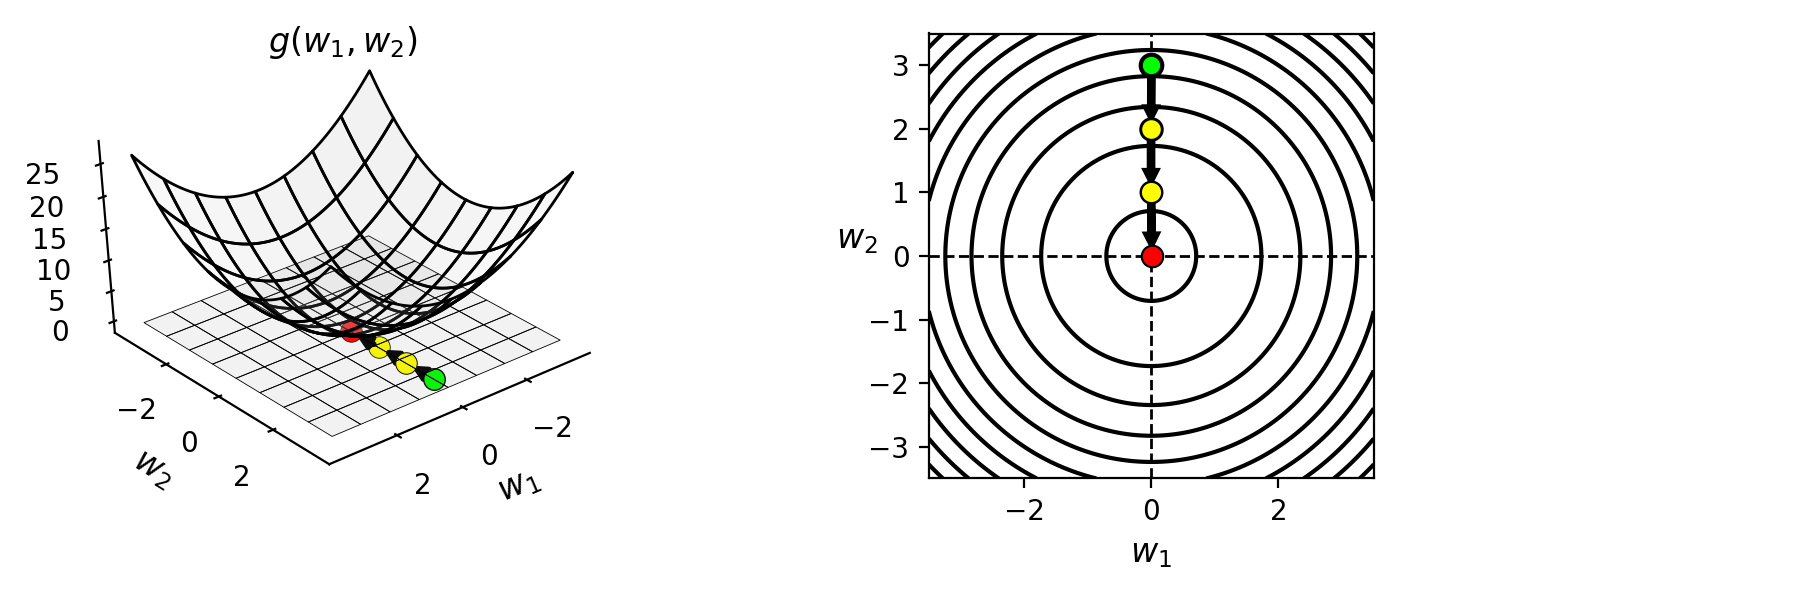

In [4]:
# define function, and points at which to take derivative
g = lambda w: np.dot(w.T,w) + 2
w_init = [0,3]; num_samples = 1000; max_steps = 30;

# animate 2d slope visualizer
view = [40,50]
optlib.random_local_search.visualize3d(func=g,view = view,pt = w_init,max_steps = max_steps, num_samples = num_samples,wmax=max(w_init[0],w_init[1]),axes = True)

#### <span style="color:#a50e3e;">Example 4. </span>  Random local search applied to minimize a simple quadratic

As another example, we minimize the function

$$
g(w_1,w_2) = \text{tanh}(4w_1 + 4w_2) + \text{max}(0.4w_1^2,1) + 1
$$

using random local search initiated at $\mathbf{w}^0 = \begin{bmatrix} 2 \\ 2 \end{bmatrix}$, setting $P = 10$ and a maximum of 5 iterations. 

<IPython.core.display.Javascript object>


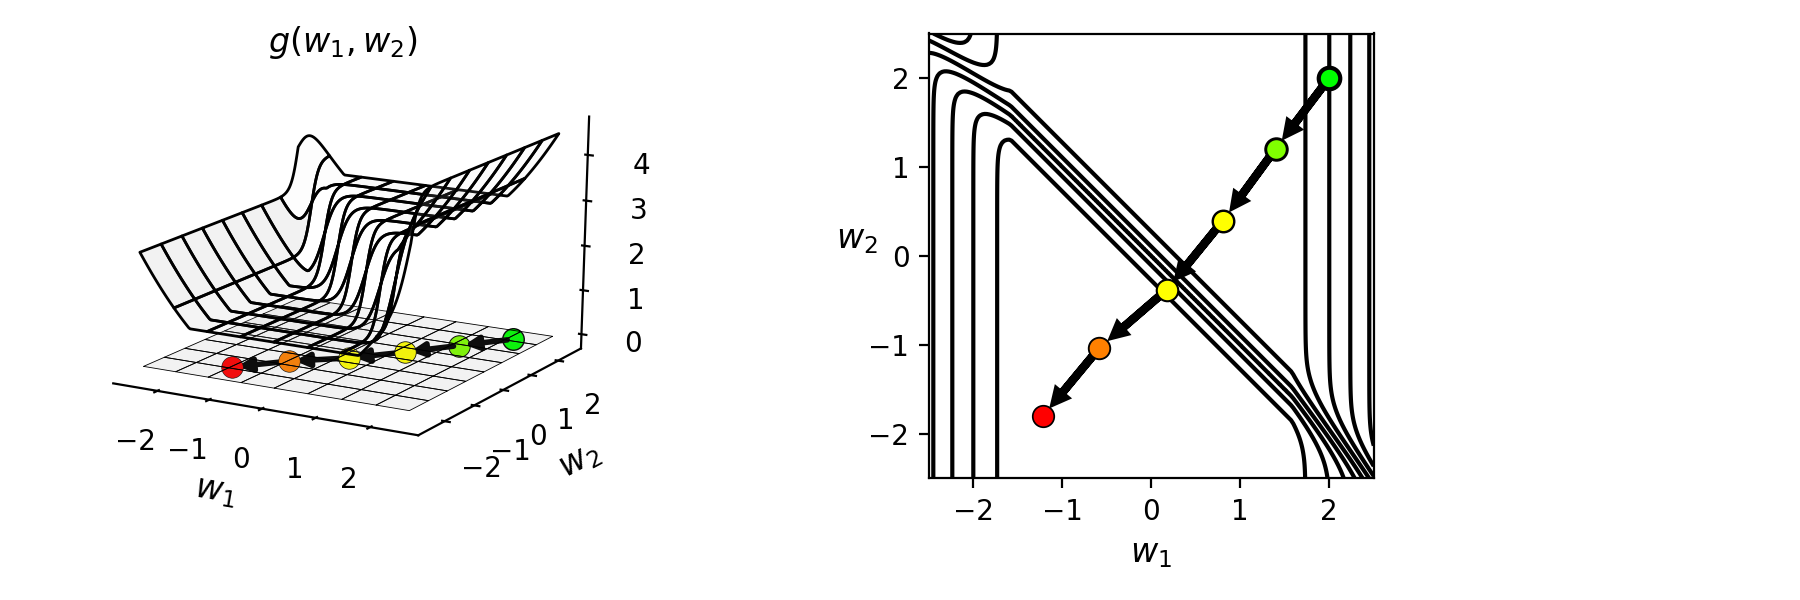

In [5]:
# define function, and points at which to take derivative
g = lambda w: np.tanh(4*w[0] + 4*w[1]) + max(0.4*w[0]**2,1) + 1
w_init = [2,2]; max_steps = 5; num_samples = 10;

# animate 2d slope visualizer
view = [20,-60]
optlib.random_local_search.visualize3d(func=g,view = view,pt = w_init,max_steps = max_steps, num_samples = num_samples,wmax=max(w_init[0],w_init[1]))

## 3.3  The formal description of local random search

At the first step of the random local search algorithm we move from our initialization $\mathbf{w}^0$ to a new point $\mathbf{w}^1=\mathbf{w}^0+\mathbf{d}$, in a unit-length descent direction $\mathbf{d}$ from the initial point 

\begin{array}
\
\underset{\mathbf{d}}{\text{minimize}}\,\,\,g\left(\mathbf{w}^0 + \mathbf{d}^{\,}\right) \\
  \text{subject to} \,\, \Vert \mathbf{d} \Vert_2 = 1
\end{array}

Likewise at the $k^{th}$ step of the algorithm, we have

\begin{array}
\
\underset{\mathbf{d}}{\text{minimize}}\,\,\,g\left(\mathbf{w}^{k-1} + \mathbf{d}^{\,}\right) \\
  \text{subject to} \,\, \Vert \mathbf{d} \Vert_2 = 1
\end{array}

Likewise at the $k^{th}$ step of the algorithm, we have

\begin{array}
\
\underset{\mathbf{d}}{\text{minimize}}\,\,\,g\left(\mathbf{w}^{k-1} + \mathbf{d}^{\,}\right) \\
  \text{subject to} \,\, \Vert \mathbf{d} \Vert_2 = 1
\end{array}

In general, we cannot solve this constrained problem 'by hand'. If we could there would be no need to perform the random sampling, which again is just our attempt to approximately solve this problem.

## 3.4  Step length rules

- Thus far at each step of the random local search algorithm we always have that $\Vert \mathbf{w}^k - \mathbf{w}^{k-1} \Vert_2 = \Vert \mathbf{w}^{k-1} + \mathbf{d} - \mathbf{w}^{k-1} \Vert_2  = \Vert \mathbf{d}  \Vert_2 = 1$

- It is not always advantages to take steps of this length, as we illustrate in the following example.

#### <span style="color:#a50e3e;">Example 5. </span>  Unit length steps fail to converge to global minimum

Here we re-run the random local search algorithm using the same simple quadratic and algorithm settings as described in Example 3, this time initialized differently at $\mathbf{w}^0 = \begin{bmatrix} 1.5 \\ 2 \end{bmatrix}$.

<IPython.core.display.Javascript object>


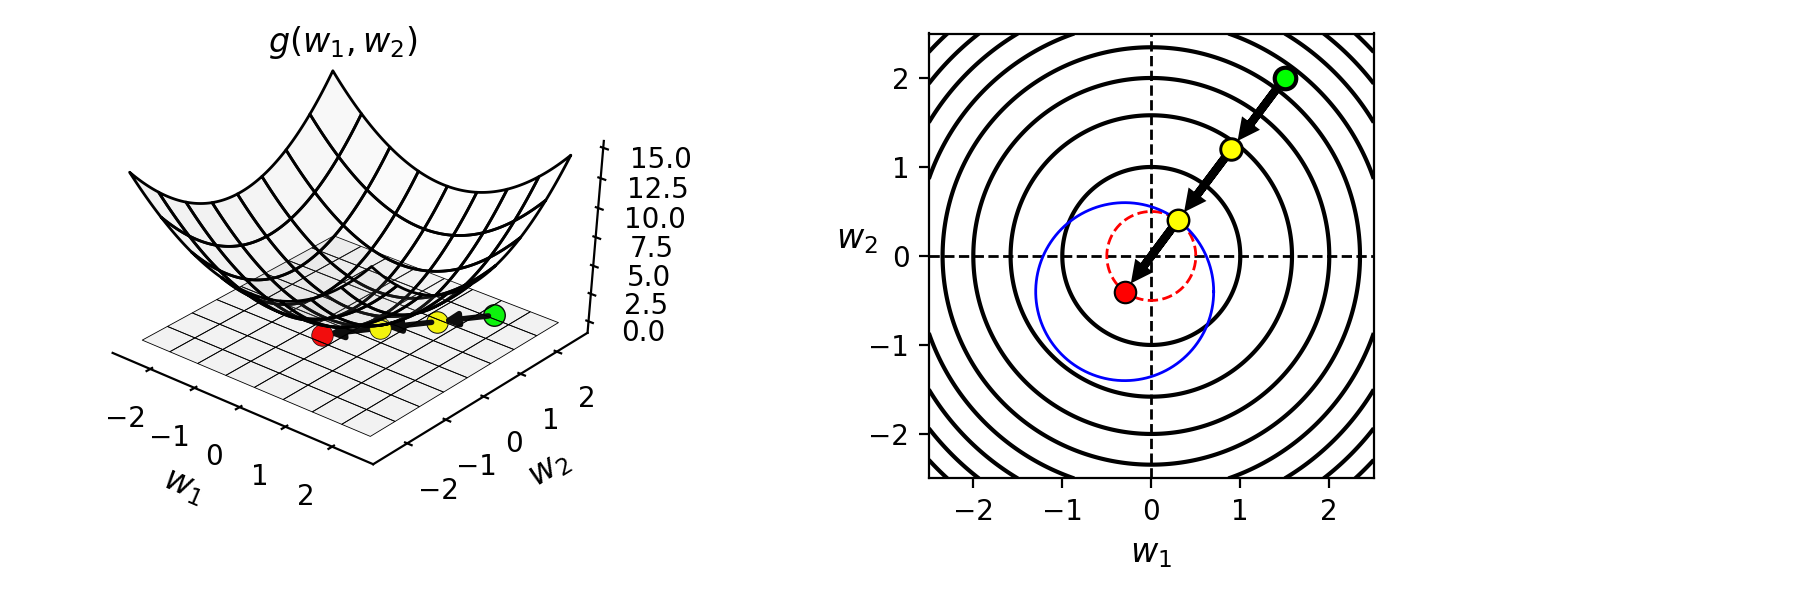

In [6]:
# define function, and points at which to take derivative
g = lambda w: np.dot(w.T,w) + 2
w_init = [1.5,2]; num_samples = 1000; max_steps = 30;

# animate 2d slope visualizer
view = [40,-50]
optlib.random_local_search.visualize3d(func=g,view = view,pt = w_init,max_steps = max_steps, num_samples = num_samples,wmax=max(w_init[0],w_init[1]),plot_final = True,axes = True)

We can easily adjust the random local search algorithm so that we can move at each step with whatever length we wish - by introducing a *steplength* parameter $\alpha$, also often referred to as a *learning rate*. 

$$
\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha\mathbf{d}^{\,}
$$

The length of this step is now equal to the steplength $\alpha$, as

$$
\Vert \mathbf{w}^k - \mathbf{w}^{k-1} \Vert_2 = \Vert \mathbf{w}^{k-1} + \alpha\mathbf{d} - \mathbf{w}^{k-1} \Vert_2  = \Vert \alpha \mathbf{d}  \Vert_2 = \alpha \Vert \mathbf{d}  \Vert_2 = \alpha
$$

Now at the $k^{th}$ step we try out $P$ random directions of length $\alpha$, taking the one that provides the greatest decrease in function value.

Steplengths can be chosen to be fixed and constant for all steps of the algorithm - e.g., we can set $\alpha = 0.1$ for all steps as in the example below - or can be adjusted at each step.  We describe a common instance of the latter idea after the next example.

#### <span style="color:#a50e3e;">Example 6. </span>  A smaller steplength for the previous example

Here we use the same quadratic and algorithm settings as described in the previous example, except we now introduce a steplength and set its value to $\alpha = 0.1$.

<IPython.core.display.Javascript object>


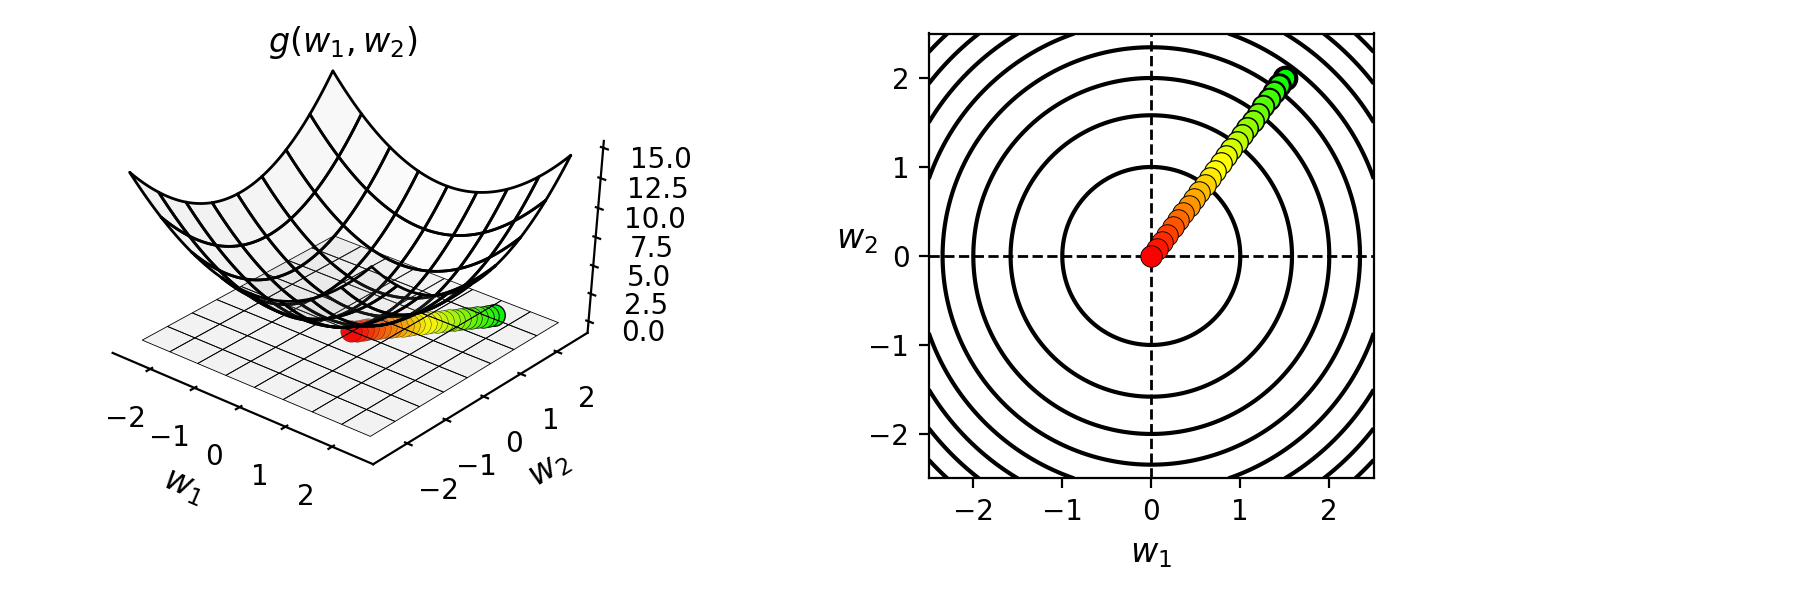

In [7]:
# define function, and points at which to take derivative
g = lambda w: np.dot(w.T,w) + 2
w_init = [1.5,2]; num_samples = 1000; max_steps = 30; steplength = 0.1;

# animate 2d slope visualizer
view = [40,-50]
optlib.random_local_search.visualize3d(func=g,view = view,pt = w_init,max_steps = max_steps, num_samples = num_samples,steplength = steplength,wmax=max(w_init[0],w_init[1]),plot_final = True,axes = True)

We need to be careful in choosing the steplength value with this simple quadratic, and by extension any general function.  If - for example - we run the same experiment again but cut the steplength down to $\alpha = 0.07$ we do not reach the global minimum.

<IPython.core.display.Javascript object>


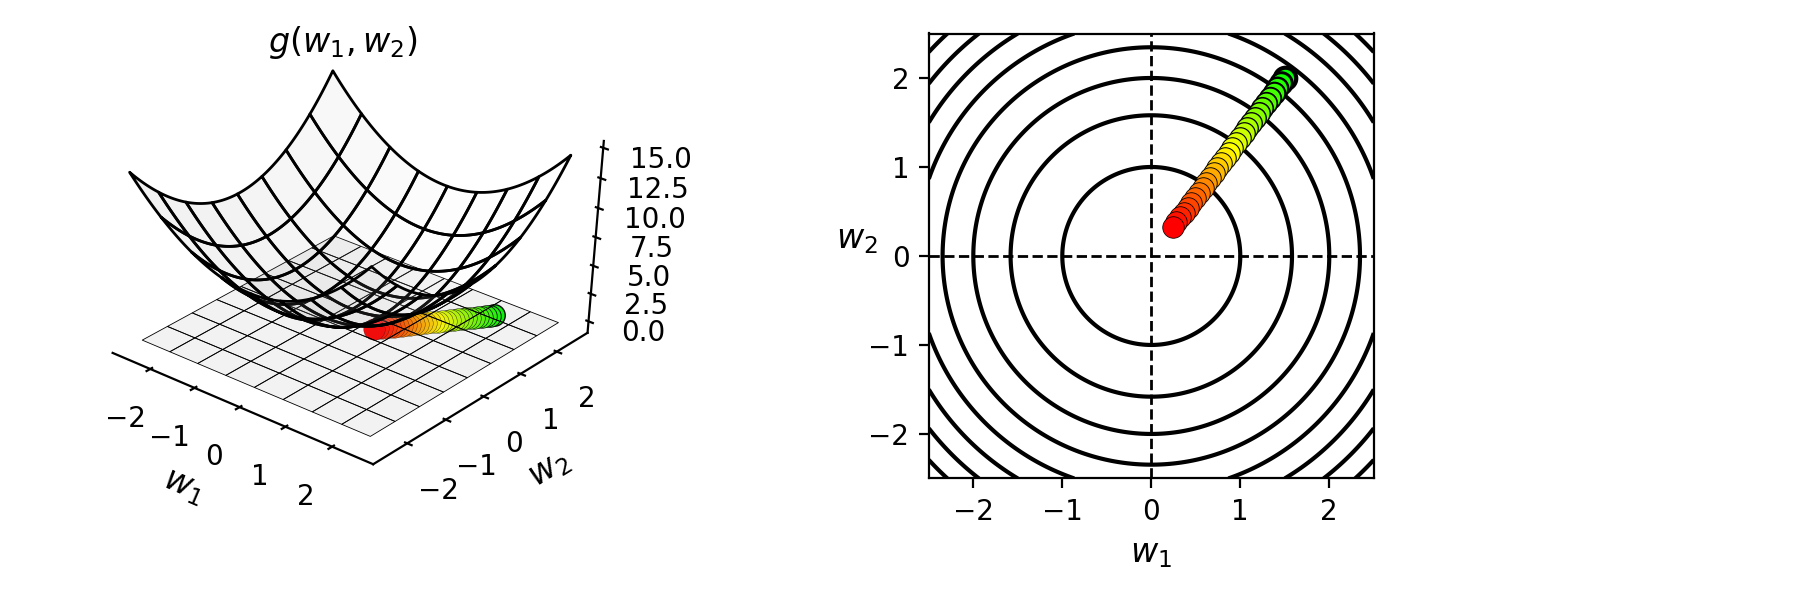

In [8]:
# define function, and points at which to take derivative
g = lambda w: np.dot(w.T,w) + 2
w_init = [1.5,2]; num_samples = 1000; max_steps = 30; steplength = 0.07;

# animate 2d slope visualizer
view = [40,-50]
optlib.random_local_search.visualize3d(func=g,view = view,pt = w_init,max_steps = max_steps, num_samples = num_samples,steplength = steplength,wmax=max(w_init[0],w_init[1]),axes = True)

In general the combination of **steplength** and **maximum number of iterations** are best chosen together.

The trade-off here is simple: a small stepsize combined with a large number of steps can guarantee convergence to towards a local minimum, but can be very computationally expensive.

Conversely a large steplength and small number of maximum iterations can be cheaper but less effective at finding small evaluation points.

#### <span style="color:#a50e3e;">Example 7. </span>  Minimizing a function with many local minima using random local search

$$
g(w) = \text{sin}(3w) + 0.1w^2
$$

We initialize two runs - at $w^0 = 4.5$ and $w^0 = -1.5$.  For both runs we use a steplength of $\alpha = 0.1$ fixed for all 10 iterations.

<IPython.core.display.Javascript object>


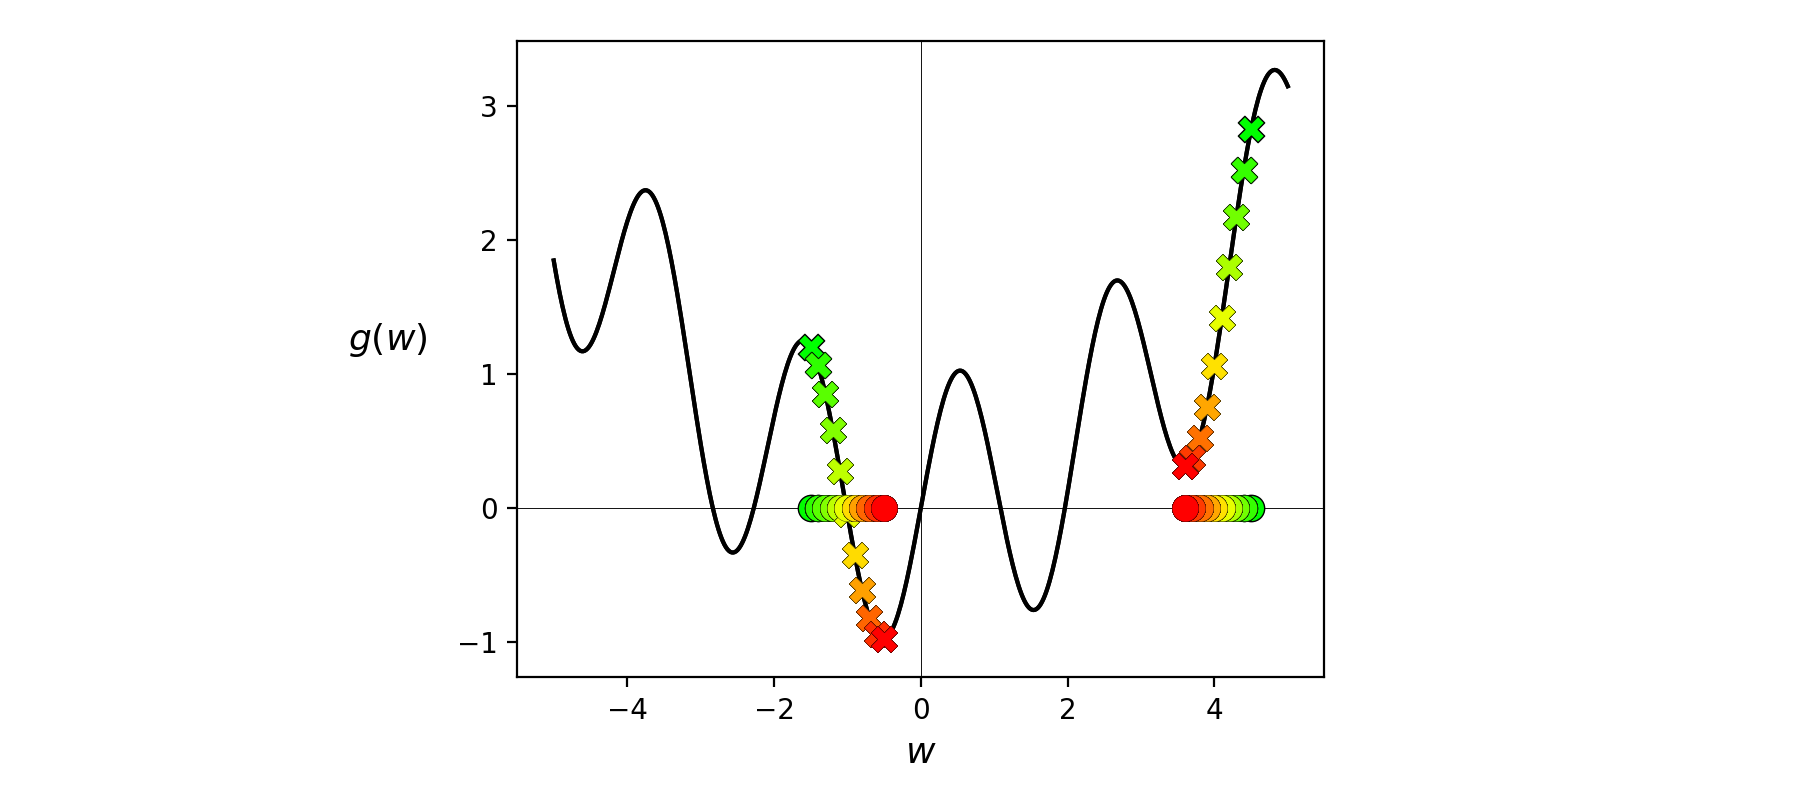

In [10]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.sin(3*w) + 0.1*w**2
w_inits = [4.5,-1.5]; steplength = 0.1; max_steps = 10; num_samples = 10;

# run the visualizer for our chosen input function, initial point, and step length alpha
optlib.random_local_search.draw_2d(g,steplength,max_steps,w_inits,num_samples,wmin = -5,wmax = 5)

### Diminishing steplength 

Instead of keeping steplength fixed at a low value, we can change its value at each step.

A common way of doing this is to set the steplength to $\alpha = \frac{1}{k}$ at the $k^{th}$ step of the process.

This way, in $K$ steps, the algorithm can travel a (maximum) distance of

$$
\sum_{k=1}^{K} \Vert \mathbf{w}^k - \mathbf{w}^{k-1} \Vert_2 = \sum_{k=1}^{K}\frac{1}{k}
$$

The beauty of this choice of stepsize is that

- clearly the stepsize decreases to zero as $k$ increases i.e., $\alpha = \frac{1}{k} \longrightarrow 0$

- the total distance traveled by the algorithm goes to infinity as $k$ increases, i.e., $\sum_{k=1}^{K}\frac{1}{k} \longrightarrow \infty$, which in theory means that an algorithm employing this steplength rule can move around an infinite distance in search of a minimum.

#### <span style="color:#a50e3e;">Example 8. </span>  Using a diminishing steplength with the previous example

Here we use the exact same quadratic function and algorithm settings as in Example 6, but employ the diminishing stepsize rule setting $\alpha = \frac{1}{k}$ at the $k^{th}$ step of the process.

<IPython.core.display.Javascript object>


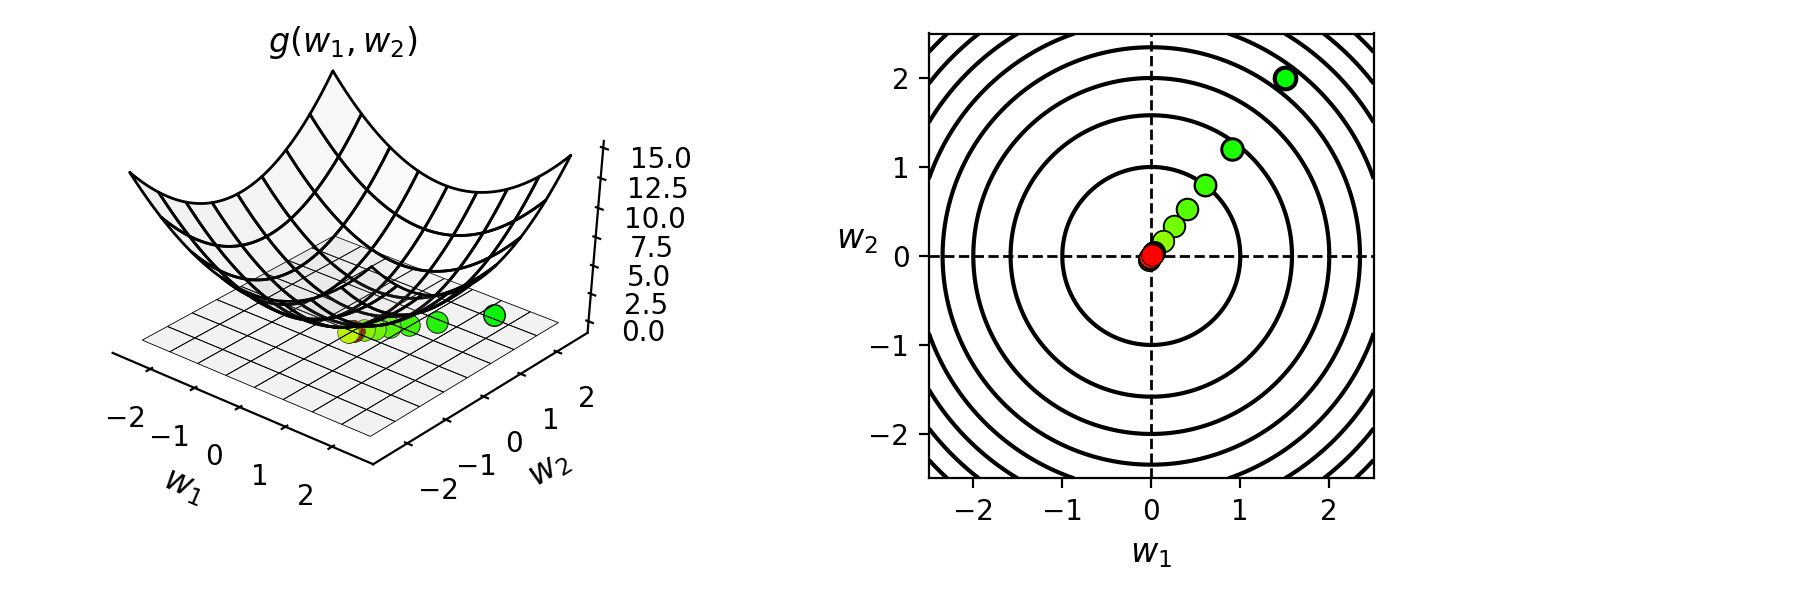

In [9]:
# define function, and points at which to take derivative
g = lambda w: np.dot(w.T,w) + 2
w_init = [1.5,2]; num_samples = 1000; max_steps = 30; steplength = 'diminish';

# animate 2d slope visualizer
view = [40,-50]
optlib.random_local_search.visualize3d(func=g,view = view,pt = w_init,max_steps = max_steps, num_samples = num_samples,steplength = steplength,wmax=max(w_init[0],w_init[1]),axes = True)

### Random local search (with steplength)

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> initial point $\mathbf{w}^0$, maximum number of steps $K$, number of random samples per step $P$, a steplength $\alpha$ or diminishing steplength rule<br>


<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,k = 1...K$<br>


<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; compute $P$ random directions $\left\{ \mathbf{d}^{p}\right\} _{p=1}^{P}$<br>


<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; find $s = \underset{p=1...P}{\text{argmin}}\,\,g\left(\mathbf{w}^{k-1} + \alpha \mathbf{d}^p\right)$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; set $\mathbf{d}^{k} = \mathbf{d}^{s}$<br>


<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; form new point $\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha\mathbf{d}^k$ <br>


<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>if</code> $g\left(\mathbf{w}^k\right) > g\left(\mathbf{w}^{k-1}\right)$  <br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <strong>output:</strong> $\mathbf{w}^{k-1}$<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>break</code><br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end if</code> <br>

<strong>11:</strong>&nbsp;&nbsp; <code>end for</code> <br>

<strong>12:</strong>&nbsp;&nbsp; <strong>output:</strong> $\mathbf{w}^{K}$ <br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

## 3.5  The curse of dimensionality and random local search

Say we want to minimize

$$g\left(\mathbf{w}\right)=\mathbf{w}^{T}\mathbf{w}+2$$
starting at the point 

$$\mathbf{w}^{0}=\left[\begin{array}{c}
1\\
0\\
0\\
\vdots\\
0
\end{array}\right]_{ N\times1}$$

When $N=1$, this reduces to finding a descent direction at random for the function $g(w)=w^2$ starting at $w^0=1$.

### $N=1$

<p>
<img src= '../../mlrefined_images/math_optimization_images/hypersphere_1d.png' width="75%" height="75%"/>
</p>

There are only 2 unit directions we can move in, and we have a $\frac{1}{2}=50\%$ descent probability. 

### $N=2$

<p>
<img src= '../../mlrefined_images/math_optimization_images/hypersphere_2d.png' width="100%" height="150%"/>
</p>

$$\text{descent probability}=\frac{\text{length of yellow arc}}{\text{length of unit circle}}<\frac{1}{2}\cdot\frac{\text{length of black circle}}{\text{length of unit circle}}=0.433$$

### General $N$

$$\text{descent probability}<\frac{1}{2}\cdot\frac{\text{surface area of encompassing hypersphere of radius } \frac{\sqrt{3}}{2}}{\text{surface area of unit hypersphere}}=\frac{1}{2}\cdot\left(\frac{\sqrt{3}}{2}\right)^{N-1}$$

Random local search becomes extremely ineffective as we increase $N$.

#### <span style="color:#a50e3e;">Example 8</span> Confirming the curse of dimensionality experimentally

Here we empirically confirm the curse of dimensionality problem described above for our simple quadratic. The printout shows what portion of the sampled directions provide a decrease in function evaluation among the first $100$, $1,000$, and $10,000$ directions sampled.

<IPython.core.display.Javascript object>


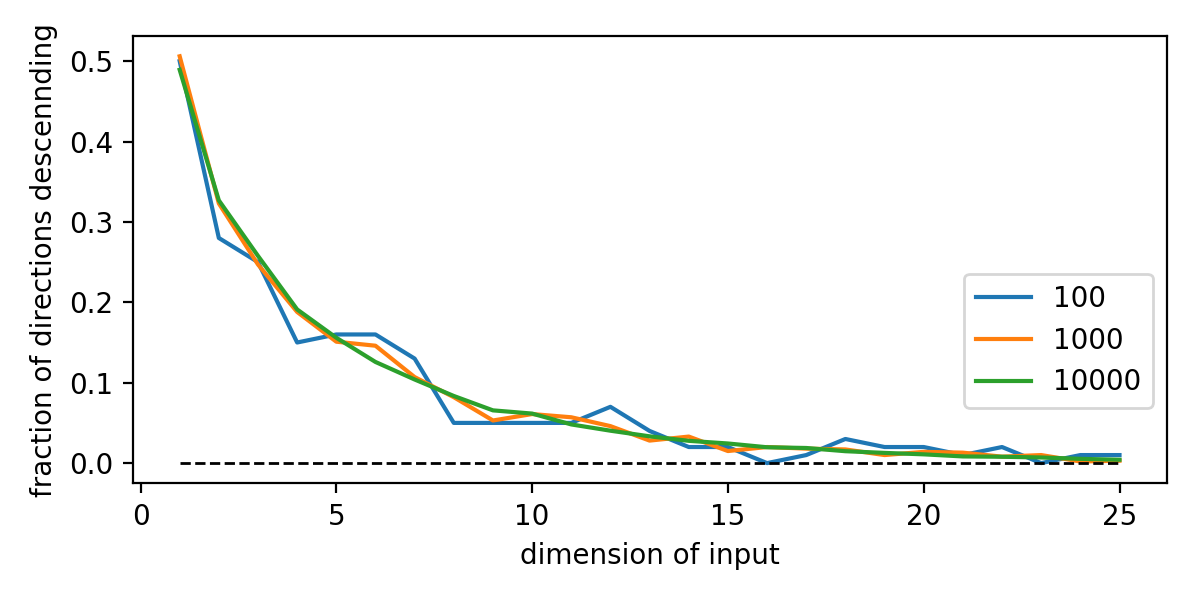

In [13]:
# run experiment for global random evaluation
optlib.random_method_experiments.random_local_experiment()

## 3.6 Conclusions

- Random local search is a good first mathematical optimization algorithm to discuss due to its **ease of implementation**, **reliance on the function alone** (and e.g., none of its derivatives), and its value as a **prototype for much more useful local methods**.

- However it is crippled by the curse of dimensionality, being highly inefficient for functions with just 30 dimensional input.

- Because many modern machine learning cost functions have input dimension $N$  on the order of thousands - to hundreds of millions - it is therefore not practically useful in the context of most machine learning / deep learning problems.

<a id='references'></a>
## References

[1]  Jeremy Watt, Reza Borhani, and Aggelos Katsaggelos. Machine Learning Refined. Cambridge University Press, 2016.